In [1]:
using AutomotiveDrivingModels
using AutoViz
using Reactive
using Interact

import PyPlot

/Users/kyle/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## functions

In [2]:
type HRHC # Hierarchical Receding Horizon Controller
    #car parameters
    car_length::Float64
    car_width::Float64
    
    v::Float64
    δ::Float64
    
    h::Int
    Δt::Float64
    
    V_MIN::Float64
    V_MAX::Float64
    V_STEPS::Int

    δ_MAX::Float64
    δ_MIN::Float64
    δ_STEPS::Int64
    
    ΔV₊::Float64
    ΔV₋::Float64
    Δδ::Float64
    
    T_MAX::Float64
    obstacles
end

In [5]:
#car parameters
car_length = 4.8 # front wheel to back wheel
car_width = 2.5
v⁰  = 0.0 # initial velocity
δ⁰ = 0.0 # initical steering angle

#controller parameters
h = 10 # look-ahead horizon
Δt = 1.0/24 # time-step size
V_MIN = 0.0 # mininmum velocity (m/s)
V_MAX = 100.0 # maximum velocity (m/s)
V_STEPS = 100 # resolution of velocity
δ_MAX = Float64(π)/8 # max steering angle (radians)
δ_MIN = -δ_MAX # min steering angle (radians)
δ_STEPS = 16 # resolution of steering angle
ΔV₊ = 1.05 / V_MAX
ΔV₋ = 2.05 / V_MAX
Δδ = Float64(π)/16

#track parameters
lane_width = 4.0*DEFAULT_LANE_WIDTH
radius = 45.0
edge_buffer = 0.25
T_MAX = lane_width/2.0 - car_width/2.0 - edge_buffer # max allowable projection distance from center of lane

obstacles = Set()

myHRHC = HRHC(car_length,car_width,v⁰,δ⁰,h,Δt,V_MIN,V_MAX,V_STEPS,δ_MAX,δ_MIN,δ_STEPS,ΔV₊,ΔV₋,Δδ,T_MAX,obstacles)

HRHC(4.8,2.5,0.0,0.0,10,0.041666666666666664,0.0,100.0,100,0.39269908169872414,-0.39269908169872414,16,0.0105,0.020499999999999997,0.19634954084936207,4.5,Set{Any}())

In [ ]:
function obstacleCheck(pos, obstacles)
    return true
end

In [6]:
# Return a library of motion primitives (arcs of constant radius) representing short paths that the car can follow.
function MotionPrimitives(
    car_length::Float64=4.8,
    v_min::Float64=0, 
    v_max::Float64=99, 
    v_steps::Int=100, 
    δ_max::Float64=Float64(π)/4, # max steering angle
    δ_steps::Int=20, # resolution of steering angle
    Δt::Float64=.05, # size of time-steps
    h::Int=10 # lookahead horizon (in time-steps)
    )
    
    # 3D array to store motion_primitives
    motion_primitives = zeros(v_steps,2*δ_steps+1,2) # v: 0,...,99; δ: -45:45, (arc length, +/- radius)

    v = linspace(v_min,v_max,v_steps)*ones(1,2*δ_steps+1)
    δ = (linspace(-δ_max,δ_max,δ_steps*2+1)*ones(1,v_steps))' # steering angle

    motion_primitives[:,:,1] = v*Δt*h # arc length = velocity * time
    motion_primitives[:,:,2] = car_length./sin(δ) # radius of curvature (+ or -)
    motion_primitives[:,1+δ_steps,2] = Inf; # radius of curvature is infinite if steering angle = 0
    
    destination_primitives = zeros(v_steps,2*δ_steps+1,h,3) # lookup table defining car's location at each of next h time steps

    for i = 1:h
        # angle = 2π * arc_length / r
        dθ = v*Δt*i ./ abs(motion_primitives[:,:,2])
        
        # dX = abs(radius) * sin(angle)
        destination_primitives[:,:,i,1] = abs(motion_primitives[:,:,2]) .* sin(dθ)
        destination_primitives[:,1+δ_steps,i,1] = v[:,1+δ_steps]*Δt*i # centerline
        
        # dY = radius * (1 - cos(angle))
        destination_primitives[:,:,i,2] = motion_primitives[:,:,2].*(1 - cos(dθ))
        destination_primitives[:,1+δ_steps,i,2] = 0 # centerline
        
        destination_primitives[:,:,i,3] = dθ
    end
    
    # motion_primitives[v, δ, 1,2] = s (arc_length), r (radius of curvature)
    # destination_primitives are index by [v, δ, h, 1,2,3] = dx, dy, dθ = changes in x, y and θ after h time steps
    return v, δ, motion_primitives, destination_primitives

end

MotionPrimitives (generic function with 9 methods)

In [7]:
# Return a library of motion primitives (arcs of constant radius) representing short paths that the car can follow.
function MotionPrimitives(hrhc::HRHC)
    car_length=hrhc.car_length
    car_width=hrhc.car_width
    
    h=hrhc.h
    Δt=hrhc.Δt
    
    v_min = hrhc.V_MIN
    v_max = hrhc.V_MAX
    v_steps = hrhc.V_STEPS

    δ_max = hrhc.δ_MAX
    δ_min = hrhc.δ_MIN
    δ_steps = hrhc.δ_STEPS
    
    # 3D array to store motion_primitives
    motion_primitives = zeros(v_steps,2*δ_steps+1,2) # v: 0,...,99; δ: -45:45, (arc length, +/- radius)

    v = linspace(v_min,v_max,v_steps)*ones(1,2*δ_steps+1)
    δ = (linspace(-δ_max,δ_max,δ_steps*2+1)*ones(1,v_steps))' # steering angle

    motion_primitives[:,:,1] = v*Δt*h # arc length = velocity * time
    motion_primitives[:,:,2] = car_length./sin(δ) # radius of curvature (+ or -)
    motion_primitives[:,1+δ_steps,2] = Inf; # radius of curvature is infinite if steering angle = 0
    
    destination_primitives = zeros(v_steps,2*δ_steps+1,h,3) # lookup table defining car's location at each of next h time steps

    for i = 1:h
        # angle = 2π * arc_length / r
        dθ = v*Δt*i ./ abs(motion_primitives[:,:,2])
        
        # dX = abs(radius) * sin(angle)
        destination_primitives[:,:,i,1] = abs(motion_primitives[:,:,2]) .* sin(dθ)
        destination_primitives[:,1+δ_steps,i,1] = v[:,1+δ_steps]*Δt*i # centerline
        
        # dY = radius * (1 - cos(angle))
        destination_primitives[:,:,i,2] = motion_primitives[:,:,2].*(1 - cos(dθ))
        destination_primitives[:,1+δ_steps,i,2] = 0 # centerline
        
        destination_primitives[:,:,i,3] = dθ
    end
    
    # motion_primitives[v, δ, 1,2] = s (arc_length), r (radius of curvature)
    # destination_primitives are index by [v, δ, h, 1,2,3] = dx, dy, dθ = changes in x, y and θ after h time steps
    return v, δ, motion_primitives, destination_primitives

end

MotionPrimitives (generic function with 10 methods)

In [8]:
# quadratic logical mask
function QuadraticMask!(library)
    A = size(library)[1]
    B = size(library)[2]
    X = linspace(0,99,A)*ones(1,B)
    Y = ones(A,1)*linspace(-20,20,B)'
    f = 24*Y.^2 + X.^2
    mask = 1.0*(f.<10000)
    
#     fig = figure()
#     ax = gca()
#     p = scatter(X,Y.*mask)
#     xlabel("velocity")
#     ylabel("steering angle")
#     fig[:canvas][:draw]()

    if length(size(library)) == 3
        for i in 1 : size(library)[3]
            library[:,:,i] = library[:,:,i] .* mask
        end
    end
    if length(size(library)) == 4
        for i in 1 : size(library)[3]
            for j in 1 : size(library)[4]
                library[:,:,i,j] = library[:,:,i,j] .* mask
            end
        end
    end
end

QuadraticMask! (generic function with 1 method)

In [9]:
function HRHC_Controller(v_commands, δ_commands, arc_angle_library, ΔXYθ, scene)
    global δ
    global V_MIN # mininmum velocity, m/s
    global V_MAX # maximum velocity, m/s
    global V_STEPS # resolution of velocity

    global δ_MAX # max steering angle - radians
    global δ_MIN 
    global δ_STEPS # resolution of steering angle
    global T_MAX
    
    global Δv₊ 
    global Δv₋
    
    global Δδ
    global v_history
    global δ_history
    
    # get current velocity and steering angle
    state = scene.vehicles[1].state
    v = state.v # current v
    v_norm = v / V_MAX
    δ = δ
    
    # Restrict search space to reachable states
    v_index_low = max(1, round(Int,(v_norm - Δv₋)*V_STEPS)) # index of lowest reachable v in the next time step
    v_index_high = min(V_STEPS, round(Int,(v_norm + Δv₊)*V_STEPS)) # index of highest reachable v in the next time step
    
    δ_index_low = max(1, (δ_STEPS+1) + round(Int,((δ - Δδ)/(δ_MAX - δ_MIN))*(2*δ_STEPS+1)))
    δ_index_high = min((2*δ_STEPS+1), (δ_STEPS+1) + round(Int,((δ + Δδ)/(δ_MAX - δ_MIN))*(2*δ_STEPS+1)))
    
    # legal_moves = motion_primitives[v_index_low:v_index_high,δ_index_low:δ_index_high,:]
    legal_ΔXYθ = ΔXYθ[v_index_low:v_index_high,δ_index_low:δ_index_high,10,:] # ΔX, ΔY, Δθ
    legal_v = v_commands[v_index_low:v_index_high,δ_index_low:δ_index_high]
    legal_δ = δ_commands[v_index_low:v_index_high,δ_index_low:δ_index_high]
    
    # get current global position
    pos = state.posG

    #calculate successor states
    ΔX = legal_ΔXYθ[:,:,1] * cos(pos.θ) + legal_ΔXYθ[:,:,2] * -sin(pos.θ)
    ΔY = legal_ΔXYθ[:,:,1] * sin(pos.θ) + legal_ΔXYθ[:,:,2] * cos(pos.θ)
    Δθ = legal_ΔXYθ[:,:,3]
    successor_states = zeros(size(legal_ΔXYθ))
    successor_states[:,:,1] = ΔX + pos.x
    successor_states[:,:,2] = ΔY + pos.y
    successor_states[:,:,3] = Δθ + pos.θ
    
    # project successor states onto track to see if they are legal
    s = zeros(size(successor_states[:,:,1]))
    t = zeros(size(s))
    ϕ = zeros(size(s))
    successor_states_grid = reshape(successor_states, length(successor_states[:,:,1]),3) # must reshape to index correctly
    for i in 1 : length(s)
        myProj = Vec.proj(VecSE2(successor_states_grid[i,:]), roadway) # project point onto roadway
        curve = myProj.curveproj
        #     @show myProj.tag # tag determines which segment the car is on (effects the value of s)
        s[i] = curve.ind.i + curve.ind.t # total distance traveled
        t[i] = curve.t # distance from centerline
        ϕ[i] = curve.ϕ
    end
    
    # select command with highest forward progress
    t_filter = (abs(t) .< T_MAX)
    if sum(t_filter) > 0
        eligible_s = s .* t_filter # filter out bad t values
    end

    index = indmax(eligible_s)
    cmd = ind2sub(s,index) # 
    abs_cmd = (cmd[1]+v_index_low-1, cmd[2]+δ_index_low-1)    
    
    # compute trajectory
    traj_ΔXYθ = ΔXYθ[abs_cmd[1],abs_cmd[2],:,:]

    ΔX = traj_ΔXYθ[:,1] * cos(pos.θ) + traj_ΔXYθ[:,2] * -sin(pos.θ)
    ΔY = traj_ΔXYθ[:,1] * sin(pos.θ) + traj_ΔXYθ[:,2] * cos(pos.θ)
    Δθ = traj_ΔXYθ[:,3]

    trajectory = zeros(size(traj_ΔXYθ))
    trajectory[:,1] = ΔX + pos.x
    trajectory[:,2] = ΔY + pos.y
    trajectory[:,3] = Δθ + pos.θ

    # screen trajectory for collisions / validity
    traj_s = zeros(size(trajectory[:,1]))
    traj_t = zeros(size(traj_s))
    traj_ϕ = zeros(size(traj_s))

    collision=false
    valid_trajectory=true

    for i in 1 : length(traj_s)
        myProj = Vec.proj(VecSE2(trajectory[i,:]), roadway) # project point onto roadway
        curve = myProj.curveproj
        #     @show myProj.tag # tag determines which segment the car is on (effects the value of s)
        traj_s[i] = curve.ind.i + curve.ind.t # total distance traveled
        if collision
            print("COLLISION PREDICTED!!! INVALID TRAJECTORY")
            valid_trajectory=false
        end
        traj_t[i] = curve.t # distance from centerline
        if abs(traj_t[i]) > T_MAX
            print("T OUT OF BOUNDS!!!")
            valid_trajectory=false
        end
        traj_ϕ[i] = curve.ϕ
    end
    
    
    δ = δ_commands[abs_cmd[1], abs_cmd[2]]
    vP = v_commands[abs_cmd[1], abs_cmd[2]]
    
    next_state = VehicleState(VecSE2(trajectory[1,:]),roadway,v_commands[abs_cmd[1], abs_cmd[2]])
    action = NextState(next_state)
    
    
    push!(v_history,vP)
    push!(δ_history,δ)
    
    return action, δ
    
end

HRHC_Controller (generic function with 1 method)

In [67]:
function get_HRHC_action(car::HRHC, v_commands, δ_commands, arc_angle_library, ΔXYθ, scene)
    # get current state
    state = scene.vehicles[1].state
    
    v = state.v # current v
    car.v = v
    
    # get legal moves (reachable from current v, δ)
    legal_ΔXYθ, legal_v, legal_δ = getLegalMoves(car, ΔXYθ, v_commands, δ_commands)
    
    # calculate successor states
    successor_states = getSuccessorStates(state,legal_ΔXYθ)
    
    # project successor states onto track to see if they are legal
    s,t,ϕ = projectToCenterline(successor_states, roadway)
    
    # select command expected to yield highest forward progress
    abs_cmd = selectBestPath(car, roadway, s, t, ϕ)    
    
    # compute trajectory
    trajectory  = computeTrajectory(abs_cmd, ΔXYθ, state)

    # screen trajectory for collisions / validity
    out_of_bounds = screenTrajectory(trajectory, roadway, car)    
    
    next_state = VehicleState(VecSE2(trajectory[1,:]),roadway,v_commands[abs_cmd[1], abs_cmd[2]])
    action = NextState(next_state)
    
    car.δ = δ_commands[abs_cmd[1], abs_cmd[2]]
    car.v = v_commands[abs_cmd[1], abs_cmd[2]]
    
    return action
    
end

get_HRHC_action (generic function with 1 method)

## MAIN: Make single car drive around race track

In [11]:
#car parameters
global car_length = 4.8 # front wheel to back wheel
global car_width = 2.5

global V_MIN = 0.0 # mininmum velocity, m/s
global V_MAX = 100.0 # maximum velocity, m/s
global V_STEPS = 100 # resolution of velocity

global δ_MAX = Float64(π)/8 # max steering angle - radians
global δ_MIN = -δ_MAX 
global δ_STEPS = 16 # resolution of steering angle

16

In [12]:
#track parameters
lane_width = 4.0*DEFAULT_LANE_WIDTH
radius = 45.0
edge_buffer = 0.25
global T_MAX = lane_width/2.0 - car_width/2.0 - edge_buffer # max allowable projection distance from center of lane

#initialize track
srand(0)

roadway = gen_stadium_roadway(1, radius=radius, lane_width=lane_width)
roadind = RoadIndex(proj(VecSE2(0.0,-1*DEFAULT_LANE_WIDTH,0.0), roadway))

scene = Scene()
framerate = 24
context = IntegratedContinuous(1/framerate,3)

Δt=1/framerate # size of time-steps
h=10 # lookahead horizon (in time-steps)

models = Dict{Int, DriverModel}()
carcolors = Dict{Int, Colorant}()
base_speed= 20.0


vehstate = VehicleState(Frenet(roadind, roadway), roadway, base_speed+randn())
vehdef = VehicleDef(1,AgentClass.CAR, 4.8, 1.8)
push!(scene,Vehicle(vehstate, vehdef))
models[1] = Tim2DDriver(context, rec=SceneRecord(1,context.Δt, 1))
set_desired_speed!(models[1], 30.0 + 20*rand())
carcolors[1] = colorant"red"

#actions = get_actions!(Array(DriveAction, length(scene)), scene, roadway, models)
actions = Array(DriveAction, length(scene))


# function drawsim(t, dt=NaN)
#     get_actions!(actions, scene, roadway, models)
#     tick!(scene, roadway, actions, models)
#     render(scene, roadway, cam=FitToContentCamera(), car_colors=carcolors)
# end

1-element Array{AutomotiveDrivingModels.DriveAction,1}:
 #undef

In [ ]:
# ticks = fps(framerate)
# timestamps = map(_ -> time(), ticks)
# map(drawsim, timestamps)

# Run HRHC:

In [18]:
# get motion primitives
# v_commands, δ_commands, arc_angle_library, ΔXYθ = MotionPrimitives(car_length,V_MIN,V_MAX,V_STEPS,δ_MAX,δ_STEPS,Δt,h);
v_commands, δ_commands, arc_angle_library, ΔXYθ = MotionPrimitives(myHRHC)

# apply logical mask to motion primitives library - eliminate impossible turns at high speeds
QuadraticMask!(arc_angle_library)
QuadraticMask!(ΔXYθ)

# acceleration parameters
global Δv₊ = 1.05 / V_MAX # ARBITRARY MAX PERCENT INCREASE in velocity per time step
global Δv₋ = 1.55 / V_MAX # ARBITRARY MAX PERCENT DECREASE in velocity per time step 

# steering parameters
global δ = 0
global Δδ = Float64(π)/16 # ARBITRARY MAX change in steering angle per time step
global v_history = []
global δ_history = []

# action, δ = HRHC_Controller(v_commands, δ_commands, arc_angle_library, ΔXYθ, scene, δ)

0-element Array{Any,1}

In [ ]:
function drawsim(t, dt=NaN)
    actions[1],δ = HRHC_Controller(v_commands, δ_commands, arc_angle_library, ΔXYθ, scene)
    tick!(scene, roadway, actions, models)
    render(scene, roadway, cam=FitToContentCamera(), car_colors=carcolors)
end

In [ ]:
ticks = fps(framerate)
timestamps = map(_ -> time(), ticks)
map(drawsim, timestamps)

# HRHC Algorithm

### 0. Initialize motion primitives

In [14]:
# get motion primitives
v_commands, δ_commands, arc_angle_library, ΔXYθ = MotionPrimitives(car_length,V_MIN,V_MAX,V_STEPS,δ_MAX,δ_STEPS,Δt,h);

# apply logical mask to motion primitives library - eliminate impossible turns at high speeds
QuadraticMask!(arc_angle_library)
QuadraticMask!(ΔXYθ)

### 1. Identify eligible (reachable) motion primitives based on current state

In [29]:
# acceleration parameters
Δv₊ = 1.05 / V_MAX # ARBITRARY MAX PERCENT INCREASE in velocity per time step
Δv₋ = 2.05 / V_MAX # ARBITRARY MAX PERCENT DECREASE in velocity per time step 

# get current velocity
state = scene.vehicles[1].state
v = state.v # current v
v = 5.0
v_norm = v / V_MAX

# Restrict search space to reachable states
v_index_low = max(1, round(Int,(v_norm - Δv₋)*V_STEPS)) # index of lowest reachable v in the next time step
v_index_high = min(V_STEPS, round(Int,(v_norm + Δv₊)*V_STEPS)) # index of highest reachable v in the next time step

# get current steering angle
δ = 0.0
Δδ = Float64(π)/16 # ARBITRARY MAX change in steering angle per time step
# Restrict search space to reachable states
δ_index_low = max(1, (δ_STEPS+1) + round(Int,((δ - Δδ)/(δ_MAX - δ_MIN))*(2*δ_STEPS+1)))
δ_index_high = min((2*δ_STEPS+1), (δ_STEPS+1) + round(Int,((δ + Δδ)/(δ_MAX - δ_MIN))*(2*δ_STEPS+1)))

# legal_moves = motion_primitives[v_index_low:v_index_high,δ_index_low:δ_index_high,:]
legal_ΔXYθ = ΔXYθ[v_index_low:v_index_high,δ_index_low:δ_index_high,10,:] # ΔX, ΔY, Δθ
legal_v = v_commands[v_index_low:v_index_high,δ_index_low:δ_index_high]
legal_δ = δ_commands[v_index_low:v_index_high,δ_index_low:δ_index_high]
legal_ΔXYθ

4×17×3 Array{Float64,3}:
[:, :, 1] =
 0.841587  0.841625  0.841658  0.841686  …  0.841658  0.841625  0.841587
 1.26207   1.2622    1.26231   1.26241      1.26231   1.2622    1.26207 
 1.68219   1.68249   1.68276   1.68298      1.68276   1.68249   1.68219 
 2.10181   2.10241   2.10293   2.10337      2.10293   2.10241   2.10181 

[:, :, 2] =
 -0.0143976  -0.0126172  -0.0108291  …  0.0108291  0.0126172  0.0143976
 -0.0323906  -0.028386   -0.0243638     0.0243638  0.028386   0.0323906
 -0.0575734  -0.0504574  -0.0433092     0.0433092  0.0504574  0.0575734
 -0.0899388  -0.0788264  -0.0676623     0.0676623  0.0788264  0.0899388

[:, :, 3] =
 0.034212   0.0299807  0.0257314  …  0.0257314  0.0299807  0.034212 
 0.051318   0.044971   0.038597      0.038597   0.044971   0.051318 
 0.0684239  0.0599614  0.0514627     0.0514627  0.0599614  0.0684239
 0.0855299  0.0749517  0.0643284     0.0643284  0.0749517  0.0855299

In [16]:
function getLegalMoves(hrhc::HRHC,ΔXYθ, v_commands, δ_commands)
    v_norm = hrhc.v / hrhc.V_MAX

    # Restrict search space to reachable states
    v_index_low = max(1, round(Int,(v_norm - hrhc.ΔV₋)*hrhc.V_STEPS)) # index of lowest reachable v in the next time step
    v_index_high = min(hrhc.V_STEPS, round(Int, (v_norm + hrhc.ΔV₊)*hrhc.V_STEPS)) # highest reachable v in the next time step

    # Restrict search space to reachable states
    δ_index_low = max(1, (hrhc.δ_STEPS+1) + round(Int,((hrhc.δ - hrhc.Δδ)/(hrhc.δ_MAX - hrhc.δ_MIN))*(2*hrhc.δ_STEPS+1)))
    δ_index_high = min((2*hrhc.δ_STEPS+1), (hrhc.δ_STEPS+1) + round(Int,((hrhc.δ + hrhc.Δδ)/(hrhc.δ_MAX - hrhc.δ_MIN))*(2*hrhc.δ_STEPS+1)))

    # legal_moves = motion_primitives[v_index_low:v_index_high,δ_index_low:δ_index_high,:]
    legal_ΔXYθ = ΔXYθ[v_index_low:v_index_high,δ_index_low:δ_index_high,hrhc.h,:] # ΔX, ΔY, Δθ
    legal_v = v_commands[v_index_low:v_index_high,δ_index_low:δ_index_high]
    legal_δ = δ_commands[v_index_low:v_index_high,δ_index_low:δ_index_high]
    
    return legal_ΔXYθ, legal_v, legal_δ
end

getLegalMoves (generic function with 1 method)

In [36]:
myHRHC.v = 5.0
legal_ΔXYθ, legal_v, legal_δ = getLegalMoves(myHRHC, ΔXYθ, v_commands, δ_commands)
legal_ΔXYθ

4×17×3 Array{Float64,3}:
[:, :, 1] =
 0.841587  0.841625  0.841658  0.841686  …  0.841658  0.841625  0.841587
 1.26207   1.2622    1.26231   1.26241      1.26231   1.2622    1.26207 
 1.68219   1.68249   1.68276   1.68298      1.68276   1.68249   1.68219 
 2.10181   2.10241   2.10293   2.10337      2.10293   2.10241   2.10181 

[:, :, 2] =
 -0.0143976  -0.0126172  -0.0108291  …  0.0108291  0.0126172  0.0143976
 -0.0323906  -0.028386   -0.0243638     0.0243638  0.028386   0.0323906
 -0.0575734  -0.0504574  -0.0433092     0.0433092  0.0504574  0.0575734
 -0.0899388  -0.0788264  -0.0676623     0.0676623  0.0788264  0.0899388

[:, :, 3] =
 0.034212   0.0299807  0.0257314  …  0.0257314  0.0299807  0.034212 
 0.051318   0.044971   0.038597      0.038597   0.044971   0.051318 
 0.0684239  0.0599614  0.0514627     0.0514627  0.0599614  0.0684239
 0.0855299  0.0749517  0.0643284     0.0643284  0.0749517  0.0855299

### 2. Calculate resulting final state (posG) from applying each given motion primitive

In [37]:
# next_posG = scene.vehicles[1].state.posG
pos = state.posG

ΔX = legal_ΔXYθ[:,:,1] * cos(pos.θ) + legal_ΔXYθ[:,:,2] * -sin(pos.θ)
ΔY = legal_ΔXYθ[:,:,1] * sin(pos.θ) + legal_ΔXYθ[:,:,2] * cos(pos.θ)
Δθ = legal_ΔXYθ[:,:,3]

successor_states = zeros(size(legal_ΔXYθ))
successor_states[:,:,1] = ΔX + pos.x
successor_states[:,:,2] = ΔY + pos.y
successor_states[:,:,3] = Δθ + pos.θ

4×17 Array{Float64,2}:
 6.3174   6.31317  6.30892  6.30465  …  6.30465  6.30892  6.31317  6.3174 
 6.3345   6.32816  6.32178  6.31539     6.31539  6.32178  6.32816  6.3345 
 6.35161  6.34315  6.33465  6.32612     6.32612  6.33465  6.34315  6.35161
 6.36872  6.35814  6.34751  6.33685     6.33685  6.34751  6.35814  6.36872

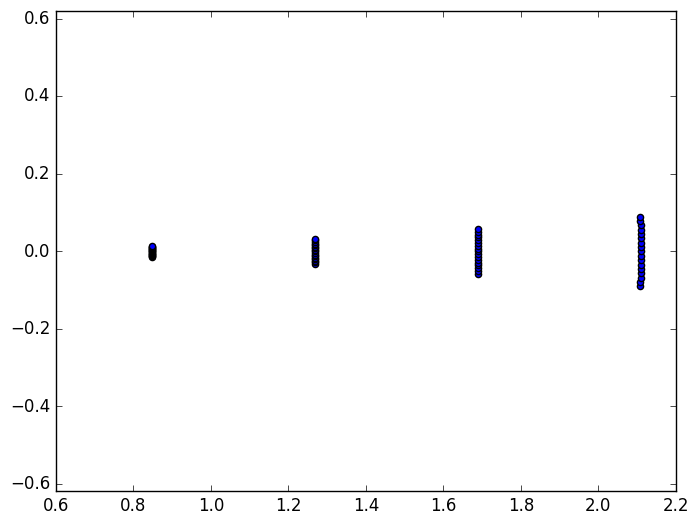

PyObject <matplotlib.collections.PathCollection object at 0x3258d97d0>

In [38]:
PyPlot.axis("equal")
PyPlot.scatter(successor_states[:,:,1],successor_states[:,:,2])

In [30]:
function getSuccessorStates(state, legal_ΔXYθ)
    pos = state.posG # global x,y,z

    ΔX = legal_ΔXYθ[:,:,1] * cos(pos.θ) + legal_ΔXYθ[:,:,2] * -sin(pos.θ)
    ΔY = legal_ΔXYθ[:,:,1] * sin(pos.θ) + legal_ΔXYθ[:,:,2] * cos(pos.θ)
    Δθ = legal_ΔXYθ[:,:,3]

    successor_states = zeros(size(legal_ΔXYθ))
    successor_states[:,:,1] = ΔX + pos.x
    successor_states[:,:,2] = ΔY + pos.y
    successor_states[:,:,3] = Δθ + pos.θ
    
    return successor_states
end

getSuccessorStates (generic function with 1 method)

In [31]:
getSuccessorStates(state,legal_ΔXYθ)

4×17×3 Array{Float64,3}:
[:, :, 1] =
 0.84769  0.847728  0.847761  0.84779  …  0.847761  0.847728  0.84769
 1.26818  1.2683    1.26842   1.26851     1.26842   1.2683    1.26818
 1.68829  1.6886    1.68886   1.68909     1.68886   1.6886    1.68829
 2.10792  2.10851   2.10903   2.10947     2.10903   2.10851   2.10792

[:, :, 2] =
 -0.0143976  -0.0126172  -0.0108291  …  0.0108291  0.0126172  0.0143976
 -0.0323906  -0.028386   -0.0243638     0.0243638  0.028386   0.0323906
 -0.0575734  -0.0504574  -0.0433092     0.0433092  0.0504574  0.0575734
 -0.0899388  -0.0788264  -0.0676623     0.0676623  0.0788264  0.0899388

[:, :, 3] =
 6.3174   6.31317  6.30892  6.30465  …  6.30465  6.30892  6.31317  6.3174 
 6.3345   6.32816  6.32178  6.31539     6.31539  6.32178  6.32816  6.3345 
 6.35161  6.34315  6.33465  6.32612     6.32612  6.33465  6.34315  6.35161
 6.36872  6.35814  6.34751  6.33685     6.33685  6.34751  6.35814  6.36872

### 3. Project posG onto track to determine if a given motion is legal (in bounds)

In [ ]:
# there is a better and faster way to search (priority queue), but I'm going to start with the easy way
s = zeros(size(successor_states[:,:,1]))
t = zeros(size(s))
ϕ = zeros(size(s))

successor_states_grid = reshape(successor_states, length(successor_states[:,:,1]),3) # must reshape to index correctly

for i in 1 : length(s)
    myProj = Vec.proj(VecSE2(successor_states_grid[i,:]), roadway) # project point onto roadway
    curve = myProj.curveproj
    #     @show myProj.tag # tag determines which segment the car is on (effects the value of s)
    s[i] = curve.ind.i + curve.ind.t # total distance traveled
    t[i] = curve.t # distance from centerline
    ϕ[i] = curve.ϕ
end

PyPlot.axis("equal")
PyPlot.scatter(s,t)

In [39]:
function projectToCenterline(successor_states, roadway)
    s = zeros(size(successor_states[:,:,1]))
    t = zeros(size(s))
    ϕ = zeros(size(s))

    successor_states_grid = reshape(successor_states, length(successor_states[:,:,1]),3) # must reshape to index correctly

    for i in 1 : length(s)
        myProj = Vec.proj(VecSE2(successor_states_grid[i,:]), roadway) # project point onto roadway
        curve = myProj.curveproj
        #     @show myProj.tag # tag determines which segment the car is on (effects the value of s)
        s[i] = curve.ind.i + curve.ind.t # total distance traveled
        t[i] = curve.t # distance from centerline
        ϕ[i] = curve.ϕ
    end
    
    return s,t,ϕ
end

projectToCenterline (generic function with 1 method)

In [40]:
s,t,ϕ = projectToCenterline(successor_states, roadway)

(
[0.00854492 0.00854492 … 0.00854492 0.00854492; 0.0126953 0.0126953 … 0.0126953 0.0126953; 25.0168 25.0168 … 25.0168 25.0168; 0.0209961 0.0209961 … 0.0209961 0.0209961],

[-0.0143976 -0.0126172 … 0.0126172 0.0143976; -0.0323906 -0.028386 … 0.028386 0.0323906; -0.0575734 -0.0504574 … 0.0504574 0.0575734; -0.0899388 -0.0788264 … 0.0788264 0.0899388],

[0.034212 0.0299807 … 0.0299807 0.034212; 0.051318 0.044971 … 0.044971 0.051318; 0.0684239 0.0599614 … 0.0599614 0.0684239; 0.0855299 0.0749517 … 0.0749517 0.0855299])

### 4. Select legal motion primitive that yields highest progress

In [ ]:
t_filter = (abs(t) .< T_MAX)
if sum(t_filter) > 0
    eligible_s = s .* t_filter # filter out bad t values
end

index = indmax(eligible_s)
cmd = ind2sub(s,index) # 
abs_cmd = (cmd[1]+v_index_low-1, cmd[2]+δ_index_low-1)
# legal_v[cmd[1],cmd[2]], legal_δ[cmd[1],cmd[2]], abs_cmd
# v_commands[abs_cmd[1], abs_cmd[2]], δ_commands[abs_cmd[1], abs_cmd[2]], abs_cmd

In [41]:
function selectBestPath(hrhc, roadway, s, t, ϕ)
    # will need roadway in order to take care of different lane segments
    t_filter = (abs(t) .< hrhc.T_MAX)
    if sum(t_filter) > 0
        eligible_s = s .* t_filter # filter out bad t values
    end

    index = indmax(eligible_s) # find get a better method of optimizing this
    
    cmd = ind2sub(s,index)
    abs_cmd = (cmd[1]+v_index_low-1, cmd[2]+δ_index_low-1)
    return abs_cmd
end

selectBestPath (generic function with 1 method)

In [45]:
abs_cmd = selectBestPath(myHRHC, roadway, s, t, ϕ)

(5,9)

### 5. Check each time step up to horizon to make sure the entire trajectory is legal

In [ ]:
# compute trajectory
traj_ΔXYθ = ΔXYθ[abs_cmd[1],abs_cmd[2],:,:]

ΔX = traj_ΔXYθ[:,1] * cos(pos.θ) + traj_ΔXYθ[:,2] * -sin(pos.θ)
ΔY = traj_ΔXYθ[:,1] * sin(pos.θ) + traj_ΔXYθ[:,2] * cos(pos.θ)
Δθ = traj_ΔXYθ[:,3]

trajectory = zeros(size(traj_ΔXYθ))
trajectory[:,1] = ΔX + pos.x
trajectory[:,2] = ΔY + pos.y
trajectory[:,3] = Δθ + pos.θ

In [43]:
function computeTrajectory(cmd_index, ΔXYθ, state)
    pos = state.posG
    
    traj_ΔXYθ = ΔXYθ[cmd_index[1],cmd_index[2],:,:]
    
    ΔX = traj_ΔXYθ[:,1] * cos(pos.θ) + traj_ΔXYθ[:,2] * -sin(pos.θ)
    ΔY = traj_ΔXYθ[:,1] * sin(pos.θ) + traj_ΔXYθ[:,2] * cos(pos.θ)
    Δθ = traj_ΔXYθ[:,3]

    trajectory = zeros(size(traj_ΔXYθ))
    trajectory[:,1] = ΔX + pos.x
    trajectory[:,2] = ΔY + pos.y
    trajectory[:,3] = Δθ + pos.θ
    
    return trajectory
end

computeTrajectory (generic function with 1 method)

In [46]:
trajectory  = computeTrajectory(abs_cmd, ΔXYθ, state)

10×3 Array{Float64,2}:
 0.174452  -0.000575957  6.29003
 0.342793  -0.0023038    6.29687
 0.511119  -0.00518345   6.30371
 0.67942   -0.00921477   6.31055
 0.84769   -0.0143976    6.3174 
 1.01592   -0.0207316    6.32424
 1.1841    -0.0282166    6.33108
 1.35223   -0.0368522    6.33792
 1.5203    -0.0466379    6.34477
 1.68829   -0.0575734    6.35161

In [ ]:
# screen trajectory for collisions / validity
traj_s = zeros(size(trajectory[:,1]))
traj_t = zeros(size(traj_s))
traj_ϕ = zeros(size(traj_s))

collision=false
valid_trajectory=true

for i in 1 : length(traj_s)
    myProj = Vec.proj(VecSE2(trajectory[i,:]), roadway) # project point onto roadway
    curve = myProj.curveproj
    #     @show myProj.tag # tag determines which segment the car is on (effects the value of s)
    traj_s[i] = curve.ind.i + curve.ind.t # total distance traveled
    if collision
        print("COLLISION PREDICTED!!! INVALID TRAJECTORY")
        valid_trajectory=false
    end
    traj_t[i] = curve.t # distance from centerline
    if abs(traj_t[i]) > T_MAX
        print("T OUT OF BOUNDS!!!")
        valid_trajectory=false
    end
    traj_ϕ[i] = curve.ϕ
end

# @show valid_trajectory;

In [55]:
function screenTrajectory(trajectory, roadway, hrhc)
    out_of_bounds = false
    
    for i in 1 : size(trajectory,1)
        myProj = Vec.proj(VecSE2(trajectory[i,:]), roadway) # project point onto roadway
        t = myProj.curveproj.t
        if abs(t) > hrhc.T_MAX
            print("T OUT OF BOUNDS!!!")
            out_of_bounds=true
            return out_of_bounds
        end
    end
    return out_of_bounds
end

screenTrajectory (generic function with 2 methods)

In [56]:
obstacles = Set()

function obstacleCheck(pos, obstacles)
    return true
end

out_of_bounds = screenTrajectory(trajectory, roadway, myHRHC)

false

### 6. Apply the motion primitive for a single time step

In [ ]:
next_state = VehicleState(VecSE2(trajectory[1,:]),roadway,v_commands[abs_cmd[1], abs_cmd[2]])
action = NextState(next_state)

### 7. Go back to 1

# Features to add

In [ ]:
"""
##########
RoadwayTagMap[lane_tag] -> base distance around the track

##########
Optimization Objective Function
- reward progress on track
- penalize heuristic functions of ϕ, t
--- f(ϕ,t) to penalize steering away from centerline?

##########
ProximityKernel(): gives proximity to a given location against a set of locations that represent obstacles
proximity = ProximityKernel(X,Y,θ,(ObstacleCoords))
proximity = ProximityKernel(s,t,ϕ,(ObstaclesCoords))

##########
Array-based operations for a faster and more robust search through eligible motion primitives
- Search highest V candidates first
- break out of a candidate trajectory as soon as ineligible
- If no trajectory is feasible, restart full search at horizon level h-1


Cognitive hierarchy - ditribution over logit-level K


"""

In [ ]:
"""
Email update:
What I did
What I would like to do
Issues?
"""
